# Chapter 3. Statistial Experiments and Significance Testing

필요한 패키지들을 설치 및 불러오기 합니다.

In [1]:
!pip install statsmodels
!pip install wquantiles

In [2]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

데이터를 불러오기 위한 경로를 설정합니다. 반드시 필요한 csv 파일이 경로 상에 위치해야 파일을 불러올 수 있습니다.

In [3]:
DATA = "C:/Users/HwanKam/hyundai/data"

In [4]:
WEB_PAGE_DATA_CSV = DATA + '/web_page_data.csv' 
FOUR_SESSIONS_CSV = DATA + '/four_sessions.csv' 
CLICK_RATE_CSV = DATA + '/click_rates.csv'
ARM = DATA + '/arm.csv'

## < Two group comparison >

In [5]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

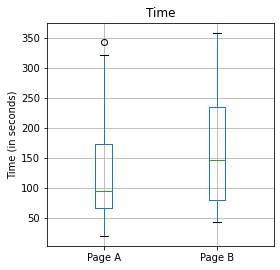

In [6]:
ax = session_times.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [7]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


## T-test

In [8]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


## t test 실습

paired data 가 아래와 같이 주어져있다고 하자. 위의 실습 코드를 참고해서 A와 B 데이터의 boxplot을 통해 데이터의 산포를 확인해보자. 그리고 t-test를 통해 두 집단군에서 차이가 존재하는지 검정해보자.

paired data에 대한 t - test는 stats.ttest_rel 을 사용한다.

In [9]:
A = [88, 83, 84, 92, 75, 79, 84, 87, 94, 91, 82, 89, 67, 68, 91]
B = [99, 94, 98, 98, 79, 92, 88, 90, 91, 96, 88, 99, 71, 79, 92]

In [10]:
print(np.mean(A))
print(np.mean(B))

83.6
90.26666666666667


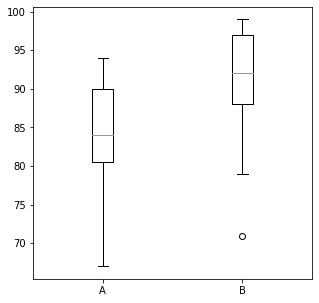

In [11]:
fig, ax = plt.subplots(figsize=(5,5))
ax.boxplot([A,B])
plt.xticks([1,2],labels = ["A","B"])
plt.show()

In [12]:
statistics, pvalue = stats.ttest_rel(A,B)

In [13]:
pvalue

0.00010131814507218846

## < Contingency table & Test > 

## Figure chi-sq distribution

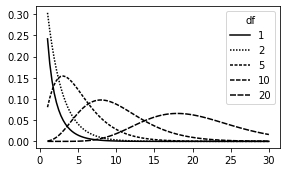

In [14]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()

## Chi-square test 

In [15]:
# Table 3-4
click_rate = pd.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


In [16]:
# Table 3-5
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [17]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


## 카이제곱 검정 실습

아래에 주어진 arm.csv 파일을 불러와서 카이제곱 검정에 관한 실습을 해보자.
데이터의 형태를 보고 pandas.crosstab 을 사용해서 분할표를 만들어보아라. 이후 카이제곱 검정 및 fisher exact test, permuation test를 실습해보자

#### chisq

In [18]:
data = pd.read_csv(ARM)

In [19]:
data.head(5)

,팔,성별
0,오른팔,여자
1,왼팔,남자
2,왼팔,여자
3,오른팔,남자
4,오른팔,남자


In [20]:
data.columns.values

array(['팔', '성별'], dtype=object)

In [21]:
contingency1 = pd.crosstab(data.팔, data.성별, margins=True, margins_name = "총합")
contingency1

성별,남자,여자,총합
팔,,,
오른팔,23,9,32
왼팔,17,5,22
총합,40,14,54


In [22]:
data1 = pd.concat([data, pd.DataFrame({"count":[1]*54})], axis=1)

In [23]:
contingency2 = pd.pivot_table(data1, index='팔', columns='성별',values='count',aggfunc=np.sum, margins=True, margins_name="총합")

In [24]:
contingency1 = pd.crosstab(data.팔, data.성별)
chisq, pvalue, df, expected = stats.chi2_contingency(contingency1)

In [25]:
expected

array([[23.7037037,  8.2962963],
       [16.2962963,  5.7037037]])

In [26]:
chisq

0.016573660714285652

In [27]:
df

1

In [28]:
pvalue

0.8975643879419304

In [29]:
1-stats.chi2.cdf(chisq, df=1)

0.8975643879419304